<a href="https://colab.research.google.com/github/adasegroup/ML2020_seminars/blob/master/seminar11/gp_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gaussian Processes (GP) with GPy

We will use GPy library for GP modeling [SheffieldML github page](https://github.com/SheffieldML/GPy).

Why **GPy**?

* Specialized library of GP models (regression, classification, GPLVM)
* Variety of covariance functions is implemented
* There are GP models for large-scale problems
* Easy to use

Uncomment and run the following line to install GPy library

In [ ]:
!pip install GPy

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import GPy

%matplotlib inline

Current documentation of GPy library can be found [here](http://gpy.readthedocs.org/en/latest/).

## Gaussian Process Regression

A data set $\left (X, \mathbf{y} \right ) = \left \{ (x_i, y_i), x_i \in \mathbb{R}^d, y_i \in \mathbb{R} \right \}_{i = 1}^N$ is given.  

Assumption:
$$
y = f(x) + \varepsilon,
$$
where $f(x)$ is a Gaussian Processes and $\varepsilon \sim \mathcal{N}(0, \sigma_n^2)$ is a Gaussian noise .

Posterior distribution
$$
y_* | X, \mathbf{y}, x_* \sim \mathcal{N}(m(x_*), \sigma(x_*)),
$$
with predictive mean and variance given by
$$
m(x_*) = \mathbf{k}^T \mathbf{K}_y^{-1} \mathbf{y} = \sum_{i = 1}^N \alpha_i k(x_*, x_i),
$$
$$
\sigma^2(x_*) = k(x_*, x_*) - \mathbf{k}^T\mathbf{K}_y^{-1}\mathbf{k},
$$
where
$$
\mathbf{k} = \left ( k(x_*, x_1), \ldots, k(x_*, x_N) \right )^T
$$
$$
\mathbf{K}_y = \|k(x_i, x_j)\|_{i, j = 1}^N + \sigma_n^2 \mathbf{I}
$$

### Exercises

1. What the posterior variance at the points from the training set is equal to? What if the noise variance is equal to 0?

2. Suppose that we want to minimize some unknown function $f(\mathbf{x})$.
   We are given a set of observations $y_i = f(\mathbf{x}_i) + \varepsilon_i$, where $\varepsilon_i \sim \mathcal{N}(0, \sigma^2)$.
   Using the observations we built a GP model $\hat{f}(\mathbf{x})$.
   Now, let us consider the value called *improvement*: 
   $$
   I(\mathbf{x}) = \max(0, y^* - f(\mathbf{x})), \quad \mbox{where } y^* \mbox{ is currently found minimum value of } f(\mathbf{x})
   $$
   To choose the next candidate for the minimum we would like to maximize the *Expected Improvement*
   $$
       EI(x) = \mathbb{E}_f I(\mathbf{x})
   $$

   1. Express the $EI(\mathbf{x})$ in terms $\Phi(\cdot)$ and $\phi(\cdot)$ - the pdf and cdf of the standard normal distribution $\mathcal{N}(0, 1)$.
   2. Assuming $\sigma = 0$ what is the value of $EI(\mathbf{x}$ for any value $y_i$ from the dataset?
   
### Solution

1. Let's apply SVD decomposition to the matrix $\mathbf{K}$: $\mathbf{K} = U D U^\top$. Then for the $i$-th point from the dataset we have
    $$
    \begin{align}
    \sigma(x_i) &= k(x_i, x_i) - \mathbf{k}^\top (\mathbf{K} + \lambda I)^{-1} \mathbf{k} \\
    &= U_i^\top D U_i - U_i^\top D U^\top (UDU^\top + \lambda I)^{-1} U^\top U D U_i \\
    &= U_i^\top ( D - D (D + \lambda I)^{-1})D) U_i < k(x_i, x_i)
    \end{align}
    $$
    If $\sigma_n = 0$, then $\sigma(x_i) = 0$
2. Let $\mu$ and $\sigma$ are mean and the variance of the GP $f(\mathbf{x})$ at point $\mathbf{x}$. Then $z = \frac{f - \mu}{\sigma} \sim \mathcal{N}(0, 1)$,
   $$
   \begin{align}
       EI(\mathbf{x}) &= \int_{-\infty}^{y^*} (y^* - f)p(f)df = \int_{-\infty}^{(y^* - \mu) / \sigma}(y^* - \sigma z - \mu)\phi(z)dz \\
       &= (y^* - \mu) \Phi\left(\frac{y^* - \mu}{\sigma}\right) - \int_{-\infty}^{(y^* - \mu) \sigma)} \sigma z \phi(z)dz \\
       &= (y^* - \mu) \Phi\left(\frac{y^* - \mu}{\sigma}\right) + \int_{-\infty}^{(y^* - \mu) \sigma)} \sigma d(-\phi(z)) \\
       &= (y^* - \mu) \Phi\left(\frac{y^* - \mu}{\sigma}\right) + \sigma \phi\left(\frac{y^* - \mu}{\sigma}\right)
   \end{align}
   $$
   If $\sigma_n = 0$, then $EI(\mathbf{x}_i) = \max(y^* - \mu(\mathbf{x}_i))$

## Building GPR model

Lets fit GPR model for function $f(x) = − \cos(\pi x) + \sin(4\pi x)$ in $[0, 1]$,
with noise $y(x) = f(x) + \epsilon$, $\epsilon \sim \mathcal{N}(0, 0.1)$. 

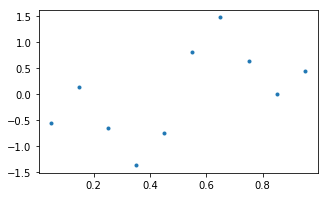

In [2]:
N = 10
X = np.linspace(0.05, 0.95, N).reshape(-1, 1)
Y = -np.cos(np.pi * X) + np.sin(4 * np.pi * X) + \
    np.random.normal(loc=0.0, scale=0.1, size=(N, 1))
plt.figure(figsize=(5, 3))
plt.plot(X, Y, '.')

#### 1. Define covariance function

The most popular kernel - RBF kernel - has 2 parameters: `variance` and `lengthscale`, $k(x, y) = \sigma^2 \exp\left ( -\dfrac{\|x - y\|^2}{2l^2}\right )$,
where `variance` is $\sigma^2$, and `lengthscale` - $l$.

In [3]:
input_dim = 1
variance = 1
lengthscale = 0.2
kernel = GPy.kern.RBF(input_dim, variance=variance,
                      lengthscale=lengthscale)

#### 2. Create GPR model


Name : GP regression
Objective : 13.42593976577423
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    0.2  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


{'dataplot': [<matplotlib.collections.PathCollection at 0x1a219bcac8>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1a219bca90>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a219cc048>]}

 /anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


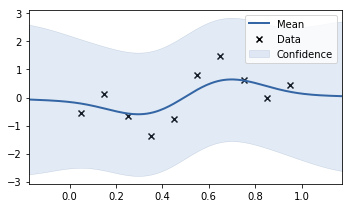

In [4]:
model = GPy.models.GPRegression(X, Y, kernel)
print(model)
model.plot(figsize=(5, 3))

### Parameters of the covariance function

Values of parameters of covariance function can be set like:  `k.lengthscale = 0.1`.

Let's change the value of `lengthscale` parameter and see how it changes the covariance function.

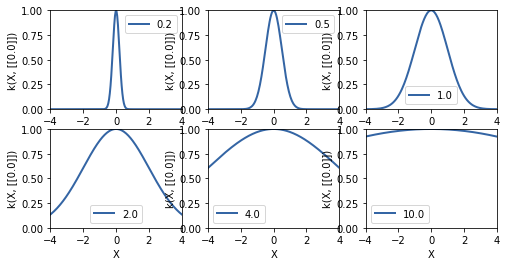

In [5]:
k = GPy.kern.RBF(1)
theta = np.asarray([0.2, 0.5, 1, 2, 4, 10])
figure, axes = plt.subplots(2, 3, figsize=(8, 4))
for t, ax in zip(theta, axes.ravel()):
    k.lengthscale = t
    k.plot(ax=ax)
    ax.set_ylim([0, 1])
    ax.set_xlim([-4, 4])
    ax.legend([t])

### Task
Try to change parameters to obtain more accurate model (we fix noise variance to some more correct value).

In [6]:
######## Your code here ########
kernel = GPy.kern.RBF(1, lengthscale=0.1)
model = GPy.models.GPRegression(X, Y, kernel)


Name : GP regression
Objective : 9.396763372865008
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    0.1  |      +ve      |        
  Gaussian_noise.variance  |   0.01  |   +ve fixed   |        


{'dataplot': [<matplotlib.collections.PathCollection at 0x1a224b58d0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1a2246c2b0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a224b5e80>]}

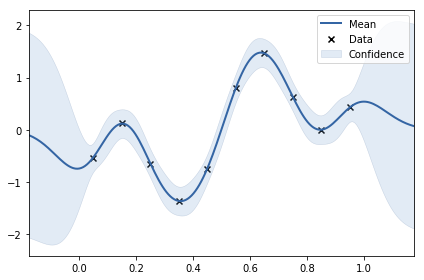

In [7]:
model.Gaussian_noise.variance.fix(0.01)
print(model)
model.plot()

### Tuning parameters of the covariance function

The parameters are tuned by maximizing likelihood. To do it just use `optimize()` method of the model.


Name : GP regression
Objective : 7.1998361366283525
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |       2.210331812790937  |      +ve      |        
  rbf.lengthscale          |     0.16483042310844623  |      +ve      |        
  Gaussian_noise.variance  |  2.2031496946666683e-09  |      +ve      |        


{'dataplot': [<matplotlib.collections.PathCollection at 0x1a225a4c88>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1a224f8b70>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a225af128>]}

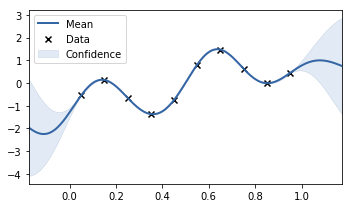

In [8]:
model = GPy.models.GPRegression(X, Y, kernel)
model.optimize()
print(model)
model.plot(figsize=(5, 3))

### Noise variance

Noise variance acts like a regularization in GP models. Larger values of noise variance lead to more smooth model.  
Let's check it: try to change noise variance to some large value, to some small value and see the results.

Noise variance accessed like this: `model.Gaussian_noise.variance = 1`

{'dataplot': [<matplotlib.collections.PathCollection at 0x1a2269e3c8>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1a22526080>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a2269e7f0>]}

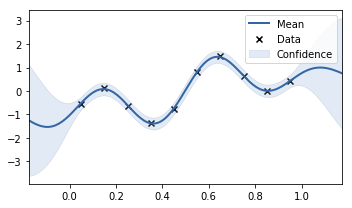

In [9]:
######## Your code here ########
model.Gaussian_noise.variance = 0.01
model.plot(figsize=(5, 3))

Now, let's generate more noisy data and try to fit model.


Name : GP regression
Objective : 31.20651975982821
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   0.7816882080723798  |      +ve      |        
  rbf.lengthscale          |   0.1016311951397994  |      +ve      |        
  Gaussian_noise.variance  |  0.14653757996951433  |      +ve      |        


{'dataplot': [<matplotlib.collections.PathCollection at 0x1a2276e080>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1a227178d0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a2276e518>]}

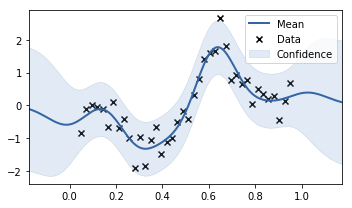

In [10]:
N = 40
X = np.linspace(0.05, 0.95, N).reshape(-1, 1)
Y = -np.cos(np.pi * X) + np.sin(4 * np.pi * X) + \
    np.random.normal(loc=0.0, scale=0.5, size=(N, 1))

kernel = GPy.kern.RBF(1)
model = GPy.models.GPRegression(X, Y, kernel)
model.optimize()
print(model)
model.plot(figsize=(5, 3))

Now, let's fix noise variance to some small value and fit the model

{'dataplot': [<matplotlib.collections.PathCollection at 0x1a22644b70>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1a2302a518>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a22650080>]}

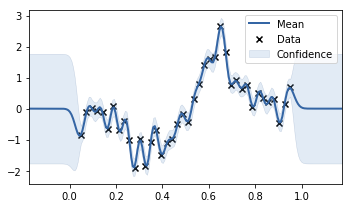

In [11]:
kernel = GPy.kern.RBF(1)
model = GPy.models.GPRegression(X, Y, kernel)
model.Gaussian_noise.variance.fix(0.01)
model.optimize()
model.plot(figsize=(5, 3))

## Approximate multi-dimensional function

In [12]:
def rosenbrock(x):
    x = 0.5 * (4 * x - 2)
    y = np.sum((1 - x[:, :-1])**2 +
                100 * (x[:, 1:] - x[:, :-1]**2)**2, axis=1)
    return y

In [13]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.metrics import mean_squared_error

def plot_2d_func(func, n_rows=1, n_cols=1, title=None):
    grid_size = 100
    x_grid = np.meshgrid(np.linspace(0, 1, grid_size), np.linspace(0, 1, grid_size))
    x_grid = np.hstack((x_grid[0].reshape(-1, 1), x_grid[1].reshape(-1, 1)))
    y = func(x_grid)
    fig = plt.figure(figsize=(n_cols * 6, n_rows * 6))
    ax = fig.add_subplot(n_rows, n_cols, 1, projection='3d')
    ax.plot_surface(x_grid[:, 0].reshape(grid_size, grid_size), x_grid[:, 1].reshape(grid_size, grid_size),
                    y.reshape(grid_size, grid_size),
                    cmap=cm.jet, rstride=1, cstride=1)
    if title is not None:
        ax.set_title(title)
    return fig

#### Here how the function looks like in 2D

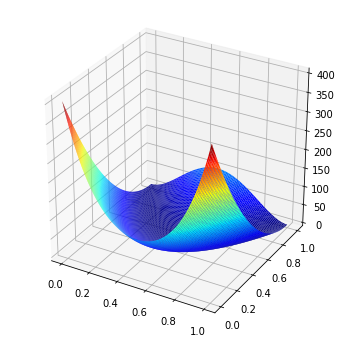

In [14]:
fig = plot_2d_func(rosenbrock)

### Training set

In [15]:
dim = 3
x_train = np.random.rand(300, dim)
y_train = rosenbrock(x_train)

### Task

Try to approximate Rosenbrock function using RBF kernel.  
**Hint**: if results are not good maybe it is due to bad local minimum. You can do one of the following things:
1. Try to use multi-start by calling `model.optimize_restarts(n_restarts)` method of the model.
2. Constrain model parameters to some reasonable bounds. You can do it for example as follows:
`model.Gaussian_noise.variance.constrain_bounded(0, 1)`


In [16]:
######## Your code here ########
kernel = GPy.kern.RBF(dim)
model = GPy.models.GPRegression(x_train, y_train.reshape(-1, 1), kernel)
model.optimize()

In [17]:
x_test = np.random.rand(3000, dim)
y_test = rosenbrock(x_test)
y_pr = model.predict(x_test)[0]

mse = mean_squared_error(y_test.ravel(), y_pr.ravel())
print('\nMSE: {}'.format(mse))


MSE: 4.4115261419461254e-05


### Covariance functions

Short info about covariance function can be printed using `print(k)`. 

In [18]:
k = GPy.kern.RBF(1)
print(k)

  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    1.0  |      +ve      |        


You can plot the covariance function using `plot()` method.

{'covariance': [[<matplotlib.lines.Line2D at 0x1a23645320>]]}

 /anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


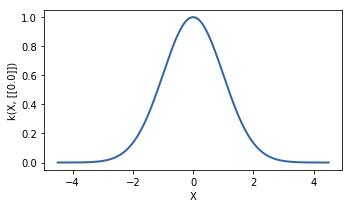

In [19]:
k.plot(figsize=(5, 3))

## More "complex" functions
The most popular covariance function is RBF. However, not all the functions can be modelled using RBF covariance function. For example, approximations of discontinuous functions will suffer from oscillations, approximation of curvy function may suffer from oversmoothing.

In [20]:
def heaviside(x):
    return np.asfarray(x > 0)


def rastrigin(x):
    """
    Parameters
    ==========
        x : ndarray - 2D array in [0, 1]
    
    Returns
    =======
        1D array of values of Rastrigin function
    """
    scale = 8  # 10.24
    x = scale * x - scale / 2
    y = 10 * x.shape[1] + (x**2).sum(axis=1) - 10 * np.cos(2 * np.pi * x).sum(axis=1)
    return y

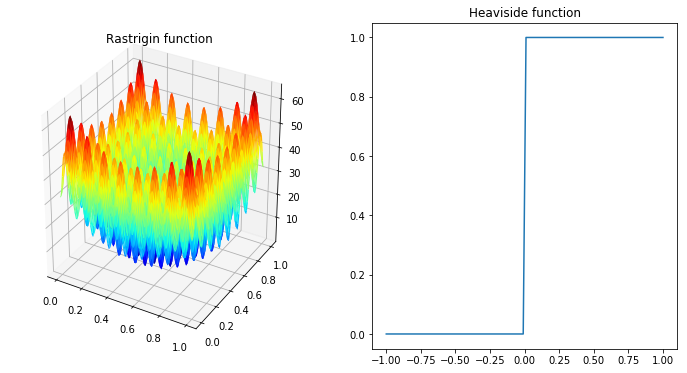

In [21]:
fig = plot_2d_func(rastrigin, 1, 2, title='Rastrigin function')

x = np.linspace(-1, 1, 100)
y = heaviside(x)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x, y)
ax.set_title('Heaviside function')
plt.show()

#### Example of oscillations
As you can see there are oscillations in viscinity of discontinuity because we are trying to approximate
discontinuous function using infinitily smooth function.

(-0.2, 1.2)

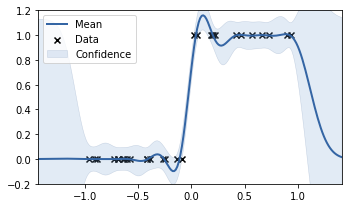

In [22]:
np.random.seed(42)
X = np.random.rand(30, 1) * 2 - 1
y = heaviside(X)

k = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

m = GPy.models.GPRegression(X, y, k)
m.optimize()
m.plot(figsize=(5, 3))
plt.ylim([-0.2, 1.2])

#### Example of oversmoothing
Actually, the GP model only approximates trend of the function.
All the curves are treated as noise.
The knowledge about this (in fact there is some repeated structure) should be incorporated into the model via kernel function.

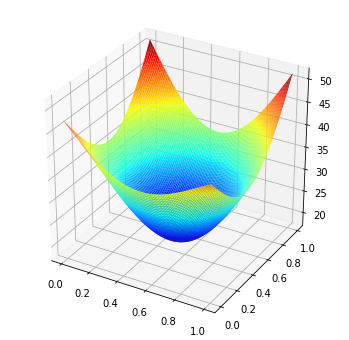

In [23]:
np.random.seed(42)

X = np.random.rand(300, 2)
y = rastrigin(X)

k = GPy.kern.RBF(input_dim=2)

m = GPy.models.GPRegression(X, y.reshape(-1, 1), k)
m.optimize()
fig = plot_2d_func(lambda x: m.predict(x)[0])

### Covariance functions in GPy

Popular covariance functions: `Exponential`, `Matern32`, `Matern52`, `RatQuad`, `Linear`, `StdPeriodic`. 

* Exponential:
$$
k(x, x') = \sigma^2 \exp \left (-\frac{r}{l} \right), \quad r = \|x - x'\|
$$

* Matern32
$$
k(x, x') = \sigma^2 \left (1 + \sqrt{3}\frac{r}{l} \right )\exp \left (-\sqrt{3}\frac{r}{l} \right )
$$

* Matern52
$$
k(x, x') = \sigma^2 \left (1 + \sqrt{5}\frac{r}{l} + \frac{5}{3}\frac{r^2}{l^2} \right ) \exp \left (-\sqrt{5}\frac{r}{l} \right )
$$

* RatQuad
$$
k(x, x') = \left ( 1 + \frac{r^2}{2\alpha l^2}\right )^{-\alpha}
$$

* Linear
$$
k(x, x') = \sum_i \sigma_i^2 x_i x_i'
$$

* Poly
$$
k(x, x') = \sigma^2 (x^T x' + c)^d
$$

* StdPeriodic
$$
k(x, x') = \sigma^2 \exp\left ( -2 \frac{\sin^2(\pi r)}{l^2}\right )
$$

## Combination of covariance functions

* Sum of covariance function is a valid covariance function:

$$
k(x, x') = k_1(x, x') + k_2(x, x')
$$

* Product of covariance functions is a valid covariance funciton:
$$
k(x, x') = k_1(x, x') k_2(x, x')
$$

### Combinations of covariance functions in GPy

In GPy to combine covariance functions you can just use operators `+` and `*`.

Let's plot some of the combinations

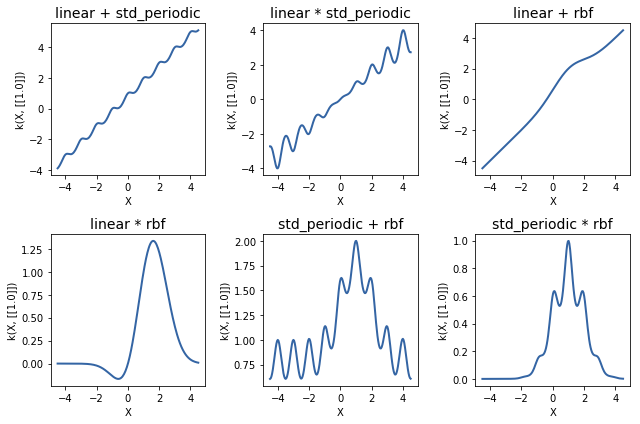

In [24]:
covariance_functions = [GPy.kern.Linear(input_dim=1), GPy.kern.StdPeriodic(input_dim=1), GPy.kern.RBF(input_dim=1, lengthscale=1)]
operations = {'+': lambda x, y: x + y, '*': lambda x, y: x * y}

figure, axes = plt.subplots(len(operations), len(covariance_functions), figsize=(9, 6))

import itertools
axes = axes.ravel()
count = 0
for j, base_kernels in enumerate(itertools.combinations(covariance_functions, 2)):
    for k, (op_name, op) in enumerate(operations.items()):
        kernel = op(base_kernels[0], base_kernels[1])
        kernel.plot(ax=axes[count])
        axes[count].set_title('{} {} {}'.format(base_kernels[0].name, op_name, base_kernels[1].name),
                              fontsize=14)
        count += 1
figure.tight_layout()

### Additive kernels

One of the popular approach to model the function of interest is
$$
f(x) = \sum_{i=1}^d f_i(x_i) + \sum_{i < j} f_{ij}(x_i, x_j) + \ldots
$$

**Example**: $\quad f(x_1, x_2) = f_1(x_1) + f_2(x_2)$  
To model it using GP use additive kernel $\quad k(x, y) = k_1(x_1, y_1) + k_2(x_2, y_2)$.

More general - add kernels each depending on subset of inputs
$$
k(x, y) = k_1(x, y) + \ldots + k_D(x, y),
$$
where, for example, $k_1(x, x') = k_1(x_1, x_1'), \; k_2(x, x') = k_2((x_1, x_3), (x_1', x_3'))$, etc.

Here is an example of ${\rm RBF}(x_1) + {\rm RBF}(x_2)$

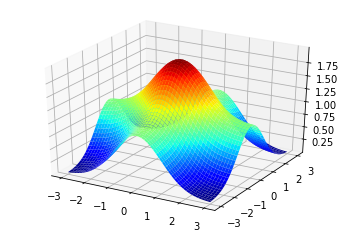

In [25]:
k1 = GPy.kern.RBF(1, active_dims=[0])
k2 = GPy.kern.RBF(1, active_dims=[1])

kernel = k1 + k2

x = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
x = np.hstack((x[0].reshape(-1, 1), x[1].reshape(-1, 1)))
z = kernel.K(x, np.array([[0, 0]]))

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

figure = plt.figure()
ax = figure.add_subplot(111, projection='3d')
ax.plot_surface(x[:, 0].reshape(50, 50), x[:, 1].reshape(50, 50), z.reshape(50, 50), cmap=cm.jet)
plt.show()

### Kernels on arbitrary types of objects

Kernels can be defined over all types of data structures: text, images, matrices, graphs, etc. You just need to define similarity between objects.

#### Kernels on categorical data

* Represent your categorical variable as a by a one-of-k encoding: $\quad x = (x_1, \ldots, x_k)$.
* Use RBF kernel with `ARD=True`: $\quad k(x , x') = \sigma^2 \prod_{i = 1}^k\exp{\left ( -\dfrac{(x_i - x_i')^2}{\sigma_i^2} \right )}$. The lengthscale will now encode whether the rest of the function changes.
* Short lengthscales for categorical variables means your model is not sharing any information between data of different categories. 

## 2 Sampling from GP

So, you have defined some complex kernel.
You can plot it to see how it looks and guess what kind of functions it can approximate.
Another way to do it is to actually generate random functions using this kernel.

GP defines distribution over functions, which is defined by its *mean function* $m(x)$ and *covariance function* $k(x, y)$: for any set $\mathbf{x}_1, \ldots, \mathbf{x}_N \in \mathbb{R}^d \rightarrow$ $\left (f(\mathbf{x}_1), \ldots, f(\mathbf{x}_N) \right ) \sim \mathcal{N}(\mathbf{m}, \mathbf{K})$,
where $\mathcal{m} = (m(\mathbf{x}_1, \ldots, \mathbf{x}_N)$, $\mathbf{K} = \|k(\mathbf{x}_i, \mathbf{x}_j)\|_{i,j=1}^N$.

Sampling procedure:

1. Generate set of points $\mathbf{x}_1, \ldots, \mathbf{x}_N$.
2. Calculate mean and covariance matrix $\mathcal{m} = (m(\mathbf{x}_1, \ldots, \mathbf{x}_N)$, $\mathbf{K} = \|k(\mathbf{x}_i, \mathbf{x}_j)\|_{i,j=1}^N$.
3. Generate vector from multivariate normal distribution $\mathcal{N}(\mathbf{m}, \mathbf{K})$.

Below try to change RBF kernel to some other kernel and see the results.

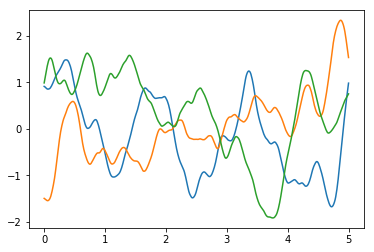

In [26]:
k = GPy.kern.Matern52(input_dim=1, lengthscale=0.3)

X = np.linspace(0, 5, 500).reshape(-1, 1)

mu = np.zeros(500)
C = k.K(X, X)

Z = np.random.multivariate_normal(mu, C, 3)

plt.figure()
for i in range(3):
    plt.plot(X, Z[i, :])

### Task

Build a GP model that predicts airline passenger counts on international flights.

In [30]:
!wget https://github.com/adasegroup/ML2020_seminars/blob/master/seminar11/data/airline.npz?raw=true

/bin/sh: wget: command not found


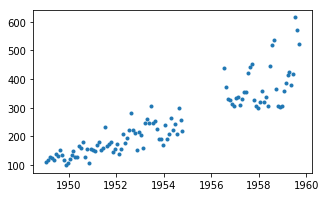

In [32]:
from scipy.io import loadmat

data = np.load('airline.npz')

X = data['X']
y = data['y']

train_indices = list(range(70)) + list(range(90, 129))
test_indices = range(70, 90)
X_train = X[train_indices]
y_train = y[train_indices]

X_test = X[test_indices]
y_test = y[test_indices]

plt.figure(figsize=(5, 3))
plt.plot(X_train, y_train, '.')
plt.show()

You need to obtain something like this
<img src="airline_result.png">

In [27]:
def plot_model(X, y, model):
    x = np.linspace(1948, 1964, 400).reshape(-1, 1)
    prediction_mean, prediction_var = model.predict(x)
    prediction_std = np.sqrt(prediction_var).ravel()
    prediction_mean = prediction_mean.ravel()
    
    plt.figure(figsize=(5, 3))
    plt.plot(X, y, '.', label='Train data')
    plt.plot(x, prediction_mean, label='Prediction')
    plt.fill_between(x.ravel(), prediction_mean - prediction_std, prediction_mean + prediction_std, alpha=0.3)

#### Let's try RBF kernel

In [28]:
######## Your code here ########
k_rbf = GPy.kern.RBF(1)

As you can see below it doesn't work ;(


Name : GP regression
Objective : 695.9234946341753
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |   291074.8089397118  |      +ve      |        
  rbf.lengthscale          |  16.675774810483787  |      +ve      |        
  Gaussian_noise.variance  |   2471.691101460296  |      +ve      |        


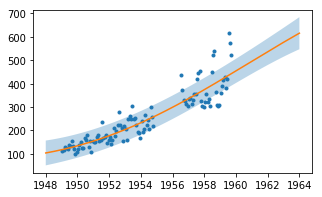

In [29]:
model = GPy.models.GPRegression(X, y, k_rbf)
model.optimize()
print(model)
plot_model(X_train, y_train, model)

We will try to model this data set using 3 additive components: trend, seasonality and noise.  
So, the kernel should be a sum of 3 kernels:  
`kernel = kernel_trend + kernel_seasonality + kernel_noise`

#### Let's first try to model trend

Trend is almost linear with some small nonlinearity, so you can use sum of linear kernel with some other which gives this small nonlinearity.

In [30]:
######## Your code here ########
k_trend = GPy.kern.Poly(1, order=1) + GPy.kern.RBF(1)


Name : GP regression
Objective : 705.5389072606191
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  sum.poly.variance        |   3366.052912739389  |      +ve      |        
  sum.poly.scale           |   3365.143742324495  |      +ve      |        
  sum.poly.bias            |   40.82859143415268  |      +ve      |        
  sum.rbf.variance         |   54870.37549511879  |      +ve      |        
  sum.rbf.lengthscale      |  11.550323699159936  |      +ve      |        
  Gaussian_noise.variance  |   2476.025964683786  |      +ve      |        


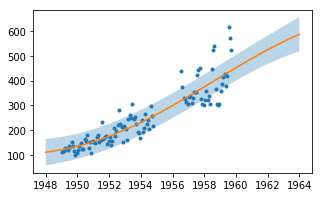

In [31]:
model = GPy.models.GPRegression(X, y, k_trend)
model.optimize()
print(model)
plot_model(X_train, y_train, model)

#### Let's model periodicity
Just periodic kernel will not work (why?).
Try to use product of periodic kernel with some other kernel (or maybe 2 other kernels).
Note that the amplitude increases with x.

In [32]:
######## Your code here ########
k_trend = GPy.kern.Poly(1, order=1) + GPy.kern.RBF(1)
k_seasonal = GPy.kern.StdPeriodic(1) * GPy.kern.RBF(1) *  GPy.kern.Linear(1)


Name : GP regression
Objective : 685.9234303480423
Number of Parameters : 12
Number of Optimization Parameters : 12
Updates : True
Parameters:
  GP_regression.                    |                value  |  constraints  |  priors
  sum.poly.variance                 |  0.19442236840627913  |      +ve      |        
  sum.poly.scale                    |  0.19571819189021708  |      +ve      |        
  sum.poly.bias                     |   0.9969959290950018  |      +ve      |        
  sum.rbf.variance                  |   139.46984407345877  |      +ve      |        
  sum.rbf.lengthscale               |   125.36620466924145  |      +ve      |        
  sum.mul.std_periodic.variance     |  0.14432346448299915  |      +ve      |        
  sum.mul.std_periodic.period       |    0.432018338659004  |      +ve      |        
  sum.mul.std_periodic.lengthscale  |   1.8003610773878735  |      +ve      |        
  sum.mul.rbf.variance              |  0.14432346439711277  |      +ve      |     

 /home/yeahrmek/miniconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:overflow encountered in true_divide
 /home/yeahrmek/miniconda3/lib/python3.6/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:overflow encountered in square
 /home/yeahrmek/miniconda3/lib/python3.6/site-packages/GPy/kern/src/rbf.py:46: RuntimeWarning:invalid value encountered in multiply


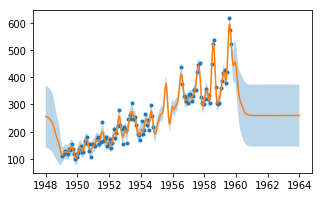

In [33]:
kernel = k_trend + k_seasonal
model = GPy.models.GPRegression(X, y, kernel)
model.optimize()
print(model)
plot_model(X_train, y_train, model)

#### Let's add noise model
The dataset is heteroscedastic, i.e. noise variance depends on x: it increases linearly with x.
Noise can be modeled using `GPy.kern.White(1)`, but it assumes that noise variance is the same at every x.
By what kernel it should be multiplied?

In [34]:
######## Your code here ########
k_trend = GPy.kern.Poly(1, order=1) + GPy.kern.RBF(1)
k_periodicity = GPy.kern.StdPeriodic(1) * GPy.kern.RBF(1) * GPy.kern.Linear(1)
k_noise = GPy.kern.White(1) * GPy.kern.Linear(1)


Name : GP regression
Objective : 647.8976986990882
Number of Parameters : 14
Number of Optimization Parameters : 14
Updates : True
Parameters:
  GP_regression.                    |                 value  |  constraints  |  priors
  sum.poly.variance                 |   0.15095487889853598  |      +ve      |        
  sum.poly.scale                    |   0.15097066976518084  |      +ve      |        
  sum.poly.bias                     |    0.9999503270531906  |      +ve      |        
  sum.rbf.variance                  |    195.31494169461735  |      +ve      |        
  sum.rbf.lengthscale               |    0.7594736297079168  |      +ve      |        
  sum.mul.std_periodic.variance     |   0.21343301055724492  |      +ve      |        
  sum.mul.std_periodic.period       |    1.0037690531138812  |      +ve      |        
  sum.mul.std_periodic.lengthscale  |    0.8090653620479369  |      +ve      |        
  sum.mul.rbf.variance              |   0.21343301070572124  |      +ve  

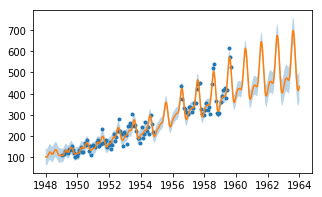

In [35]:
kernel = k_trend + k_periodicity + k_noise
model = GPy.models.GPRegression(X, y, kernel)
model.optimize()
print(model)
plot_model(X_train, y_train, model)

# Automatic covariance structure search

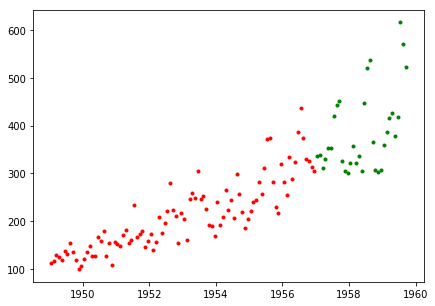

In [36]:
plt.figure(figsize=(7, 5));

X = data['X']
y = data['y']

idx_test = np.where((X[:,0] > 1957))[0]
idx_train = np.where((X[:,0] <= 1957))[0]
X_train = X[idx_train]
y_train = y[idx_train]

X_test = X[idx_test]
y_test = y[idx_test]

plt.plot(X_train, y_train, '.', color='red');
plt.plot(X_test, y_test, '.', color='green');

In [37]:
def plot_model_learned(X, y, train_idx, test_idx, model):
    prediction_mean, prediction_var = model.predict(X)
    prediction_std = np.sqrt(prediction_var).ravel()
    prediction_mean = prediction_mean.ravel()
    
    plt.figure(figsize=(7, 5))
    plt.plot(X, y, '.')
    plt.plot(X[train_idx], y[train_idx], '.', color='green')
    plt.plot(X, prediction_mean, color='red')
    plt.fill_between(X.ravel(), prediction_mean - prediction_std, prediction_mean + prediction_std, alpha=0.3)

## Expressing Sturcture Through Kernels

For example:

$$
\underbrace{\text{RBF}\times\text{Lin}}_\text{increasing trend} + \underbrace{\text{RBF}\times\text{Per}}_\text{varying-amplitude periodic} + \underbrace{\text{RBF}}_\text{residual}
$$

## Greedy Searching for the Optimum Kernel Combination

One can wonder: how to automatically search the kernel structure? We can optimize some criteria, which balance between a loss function value and the complexity of the model.
Reasinobale candidate for this is BIC-criteria:

$$
BIC = - 2. \text{Log-Liklihood} + m \cdot\log{n}
$$

where $n$ sample size and $m$ number of the parameters.

However, the procedure of fitting Gaussian Process is quite expensive $O(n^3)$. Hence,  instead of the combinatorial search through all possible combinations, we grow the kernel structure greedy.

You can find more details at the https://github.com/jamesrobertlloyd/gp-structure-search. For now, we present toy-example algorithm.

Consider the set of operations:

$$
\text{Algebra: } +,\times
$$

and the set of basic kernels:

$$
\text{Kernels: } \text{Poly}, \text{RBF}, \text{Periodic}
$$

For each level we select extenstion of our current kernel with the lowest BIC. This is an example of the possible kernel grow process (mark notes the lowest BIC at the level):

<img src='gp.png'>

In [48]:
def train_model_get_bic(X_train, y_train, kernel, num_restarts=3):
    '''
    Input:
        X_train: numpy array of train features, n*d (d>=1)
        y_train: numpy array n*1
        kernel: GPy object kern
        num_restars: number of the restarts of the optimization routine
    Output:
        bic value
    '''
    kernel = kernel.copy()
    model = GPy.models.GPRegression(X_train, y_train, kernel, None)
    model.optimize_restarts(num_restarts, verbose=False)
    
    log_ll = model.log_likelihood()
    N = X_train.shape[0]
    m = model.param_array.shape[0]
    bic = -2.*log_ll + m * np.log(N)
    
    return bic 

In [49]:
def _make_all_products(op_list, kernel_list):
    '''
    Find product pairs
    '''
    product_index = np.where(np.array(op_list) == '*')[0]
    if len(product_index) == 0:
        return kernel_list

    product_index = product_index[0]
    product_kernel = kernel_list[product_index] * kernel_list[product_index + 1]
    
    if len(op_list) == product_index + 1:
        kernel_list_copy = kernel_list[:product_index] + [product_kernel]
        op_list_copy = op_list[:product_index]
    else:
        kernel_list_copy = kernel_list[:product_index] + [product_kernel] + kernel_list[product_index + 2:]
        op_list_copy = op_list[:product_index] + op_list[product_index + 1:]
        
    return _make_all_products(op_list_copy, kernel_list_copy)


class GreedyKernel:
    '''
    Class for greedy growing kernel structure
    '''
    def __init__(self, algebra, base_kernels):
        self.algebra = algebra
        self.base_kernels = base_kernels
        self.kernel = None
        self.kernel_list = []
        self.op_list = []
        self.str_kernel = None
    
    def _make_kernel(self, op_list, kernel_list):
        '''
        Sumation in kernel experssion
        '''
        kernels_to_sum = _make_all_products(op_list, kernel_list)
        new_kernel = kernels_to_sum[0]
        for k in kernels_to_sum[1:]:
            new_kernel = new_kernel + k
        return new_kernel
    
    def init_kernel(self, X_train, y_train):
        '''
        Initialization of first kernel
        '''
        bic = np.zeros(len(self.base_kernels))
        for k, kernel in enumerate(self.base_kernels):
            bic[k] = train_model_get_bic(X_train, y_train, kernel)
        self.kernel = self.base_kernels[np.argmin(bic)]
        self.kernel_list.append(self.kernel.copy())
        self.str_kernel = str(self.kernel.name)
        
    def grow_level(self, X_train, y_train):
        '''
        Select optimal extension of current kernel 
        '''    
        best_bic = np.inf
        best_op, best_kernel = None, None
        
        for k, kernel in enumerate(self.base_kernels):
            for a, (op_name, op) in enumerate(self.algebra.items()):
                new_kernel = self._make_kernel(self.op_list + [op_name], self.kernel_list + [kernel])
                bic = train_model_get_bic(X_train, y_train, new_kernel)
                if bic < best_bic:
                    best_op = op_name
                    best_kernel = kernel
                    best_bic = bic
                
        self.kernel_list.append(best_kernel.copy())
        self.op_list.append(best_op)
        
        new_kernel = self._make_kernel(self.op_list, self.kernel_list)
        str_new_kernel = '{} {} {}'.format(self.str_kernel, best_op, best_kernel.name)
        
        return new_kernel, str_new_kernel
    
    def grow_tree(self, X_train, y_train, max_depth):
        '''
        Greedy kernel growing
        '''
        if self.kernel == None:
            self.init_kernel(X_train, y_train)
            
        for i in range(max_depth):
            self.kernel, self.str_kernel = self.grow_level(X_train, y_train)
            print(self.str_kernel)
            
    def fit_model(self, X_train, y_train, kernel, num_restarts=1):
        model = GPy.models.GPRegression(X_train, y_train, kernel)
        model.optimize_restarts(num_restarts, verbose=False)
        return model

In [50]:
# operations under kernels:

algebra = {'+': lambda x, y: x + y,
           '*': lambda x, y: x * y
          }

# basic kernels list:

poly_kern = GPy.kern.Poly(input_dim=1, order=1)

periodic_kern = GPy.kern.StdPeriodic(input_dim=1)
periodic_kern.period.constrain_bounded(1e-2, 1e1)
periodic_kern.lengthscale.constrain_bounded(1e-2, 1e1)

rbf_kern = GPy.kern.RBF(input_dim=1)
rbf_kern.lengthscale.constrain_bounded(1e-2, 1e1)

bias_kern = GPy.kern.Bias(1)

kernels_list = [poly_kern, periodic_kern, rbf_kern]

reconstraining parameters std_periodic.period
reconstraining parameters std_periodic.lengthscale
reconstraining parameters rbf.lengthscale


The algorithm is not perfect, but still it returns something reasonable.  
In order to improve it you can think of more advanced greed strategy.

 /home/yeahrmek/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning:elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


rbf + rbf
rbf + rbf * std_periodic
rbf + rbf * std_periodic + rbf
rbf + rbf * std_periodic + rbf * std_periodic


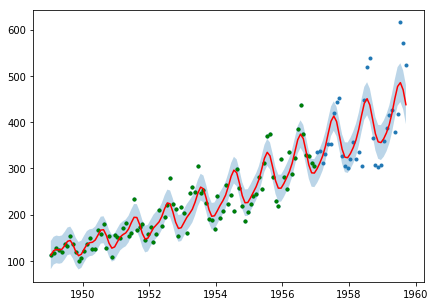

In [51]:
GK = GreedyKernel(algebra, kernels_list)
GK.grow_tree(X_train, y_train, 4)
model = GK.fit_model(X_train, y_train, GK.kernel)
plot_model_learned(X, y, idx_train, idx_test, model)

# Appendix: Gaussian Process Classification

### Classification

A data set $\left (X, \mathbf{y} \right ) = \left \{ (x_i, y_i), x_i \in \mathbb{R}^d, y_i \in \{+1, -1\} \right \}_{i = 1}^N$ is given.  

Assumption:
$$
p(y = +1 \; | \; x) = \sigma(f(x)) = \pi(x),
$$
where latent function $f(x)$ is a Gaussian Processes.

We need to produce a probabilistic prediction
$$
\pi_* = p(y_* \; | \; X, \mathbf{y}, x_*) = \int \sigma(f_*) p(f_* \; | \; X, \mathbf{y}, x_*) df_*,
$$
$$
p(f_* \; | \; X, \mathbf{y}, x_*) = \int p(f_* \; | \; X, x_*, \mathbf{f}) p(\mathbf{f} \; | \; X, \mathbf{y}) d\mathbf{f},
$$
where $p(\mathbf{f} \; |\; X, \mathbf{y}) = \dfrac{p(\mathbf{y} | X, \mathbf{f}) p(\mathbf{f} | X)}{p(\mathbf{y} | X)}$ is the posterior over the latent variables.

Both integrals are intractable.

Use approximation technique like Laplace approximation or Expectation Propagation.

In [ ]:
from matplotlib import cm

def cylinder(x):
    y = (1 / 7.0 - (x[:, 0] - 0.5)**2 - (x[:, 1] - 0.5)**2) > 0
    return y

np.random.seed(42)
X = np.random.rand(40, 2)
y = cylinder(X)

x_grid = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
y_grid = cylinder(np.hstack((x_grid[0].reshape(-1, 1), x_grid[1].reshape(-1, 1)))).reshape(x_grid[0].shape)

positive_idx = y == 1
plt.figure(figsize=(5, 3))
plt.plot(X[positive_idx, 0], X[positive_idx, 1], '.', markersize=10, label='Positive')
plt.plot(X[~positive_idx, 0], X[~positive_idx, 1], '.', markersize=10, label='Negative')
im = plt.contour(x_grid[0], x_grid[1], y_grid, 10, cmap=cm.hot)
plt.colorbar(im)
plt.legend()
plt.show()

In [ ]:
kernel = GPy.kern.RBF(2, variance=1., lengthscale=0.2, ARD=True)

model = GPy.models.GPClassification(X, y.reshape(-1, 1), kernel=kernel)
model.optimize()
print(model)


def plot_model_2d(model):

    model.plot(levels=40, resolution=80, plot_data=False, figsize=(5, 3))
    plt.plot(X[positive_idx, 0], X[positive_idx, 1], '.', markersize=10, label='Positive')
    plt.plot(X[~positive_idx, 0], X[~positive_idx, 1], '.', markersize=10, label='Negative')
    plt.legend()
    plt.show()
    
plot_model_2d(model)

Let's change lengthscale to some small value

In [ ]:
model.rbf.lengthscale = [0.05, 0.05]
plot_model_2d(model)

## Bonus Task
Try to approximate rastrigin function

In [ ]:
fig = plot_2d_func(rastrigin)

### Training set

In [ ]:
np.random.rand(42)
x_train = np.random.rand(200, 2)
y_train = rastrigin(x_train)

#### Hint: you can constrain parameters of the covariance functions, for example
`model.std_periodic.period.constrain_bounded(0, 0.2)`.

In [ ]:
######## Your code here ########
kernel = GPy.kern.RBF(2) * GPy.kern.StdPeriodic(2)
model = GPy.models.GPRegression(x_train, y_train.reshape(-1, 1), kernel)
# model.Gaussian_noise.variance.constrain_bounded(0, 0.01)
model.mul.std_periodic.period.constrain_bounded(0, 0.2)
model.optimize_restarts(5)

In [ ]:
print(model)

x_test = np.random.rand(1000, 2)
y_test = rastrigin(x_test)
y_pr = model.predict(x_test)[0]

mse = mean_squared_error(y_test.ravel(), y_pr.ravel())
print('MSE: {}'.format(mse))

fig = plot_2d_func(lambda x: model.predict(x)[0])